# Placement of products in retail stores
### Problem statement
<pre>
We would like you to implement a solution for product verification in retail stores. Specifically,
given a set of product spaces each containing some product images, write a solution to alarm a
store operator whether a product is kept in its correct product space or not. A product that doesn’t
belong to the correct product space is called a Plug
</pre>



### Data provided
<pre>
• embeddings.csv: contains embedding vectors [1280x1] of all product images.
• product_spaces.csv: contains product space info for each embedding vector.
• plug_labels.csv: contains plug label for each embedding vector.
The plug_label csv file contains binary labels. Label 0 means that the product belongs to the correct
product space and label 1 means that the product is a plug - the product doesn’t belong to the
correct product space.
</pre>


# Imports

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import random as r
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
import lightgbm as lgbm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import math
from pylab import rcParams

In [2]:
# Mounting the drive in this environment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "drive/MyDrive/zebra_cv_technical_task.zip" -d ""

Archive:  drive/MyDrive/zebra_cv_technical_task.zip
   creating: zebra_cv_technical_task/
  inflating: zebra_cv_technical_task/plug_labels.csv  
  inflating: zebra_cv_technical_task/product_spaces.csv  
  inflating: zebra_cv_technical_task/embeddings.csv  


# Loading the data

In [4]:
# https://stackoverflow.com/questions/3518778/how-do-i-read-csv-data-into-a-record-array-in-numpy
from numpy import genfromtxt

plug_labels = genfromtxt('zebra_cv_technical_task/plug_labels.csv', delimiter = ',')
# Changes shape of plug_labels from (13008,) to (13008, 1). This will be required for 'hstack'.
plug_labels = np.expand_dims(plug_labels, axis = 1)

product_spaces = genfromtxt('zebra_cv_technical_task/product_spaces.csv', delimiter = ',')
# Changes shape of product_spaces from (13008,) to (13008, 1). This will be required for 'hstack'.
product_spaces = np.expand_dims(product_spaces, axis = 1)

# This code automatically generates a matrix of shape (13008, 1280) from the 'embeddings.csv' file.
embeddings = genfromtxt('zebra_cv_technical_task/embeddings.csv')

print("plug_labels -> " + str(plug_labels.shape))
print("product_spaces -> " + str(product_spaces.shape))
print("embeddings -> " + str(embeddings.shape))

plug_labels -> (13008, 1)
product_spaces -> (13008, 1)
embeddings -> (13008, 1280)


In [5]:
# Column wise stacking of the 1280 feature embeddings, the product_space feature, and the plug_label. Hence, the 1282 columns.
data = np.hstack((embeddings, product_spaces, plug_labels))
print(data.shape)

(13008, 1282)


# Exploratory Data Analysis and Data preprocessing

In [6]:
# Creating all the column names in string format. 
cols = [str(i) for i in range(1, 1283)] 

# Making a dataframe out of this array where
# '1' to '1280' -> embedding features
# '1281' -> product_space
# '1282' -> plug_label
data_df = pd.DataFrame(data, columns = cols)
data_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282
0,-0.624101,-0.600153,0.704362,-0.851881,0.742502,-0.890739,-0.156409,-0.524309,-1.039074,0.733625,0.761620,-3.427066,1.887862,-1.167323,-1.571950,-0.709115,0.608719,0.523154,-0.409781,-1.670083,0.515849,-0.473741,0.116509,-1.386105,-2.227334,-0.892413,-0.181743,-0.770373,-2.161801,1.532797,-1.143360,-1.792788,-0.509151,0.249388,-2.081708,-0.878775,-0.070655,1.227240,-1.542970,-1.308576,...,0.813113,12.464258,0.464868,-0.262616,-0.112081,0.122632,1.619306,-1.121253,-0.098816,-2.686435,1.046831,1.219463,-0.975854,-2.073583,0.438353,-0.309581,0.902685,-3.599215,0.879937,0.129751,-0.066361,-1.428715,0.255033,-0.865855,0.788276,-0.307688,0.698798,2.269841,1.283740,-0.457047,0.833246,-0.103622,-0.339397,-0.634811,1.941443,-1.906944,-0.118666,-0.171645,6.714070e+10,0.0
1,0.199284,-0.915928,-0.068404,-0.517538,0.423785,-0.836133,-0.778267,-0.043713,-1.241188,0.576069,0.596038,-2.414939,1.400616,-1.377746,-1.340275,0.413724,0.269825,-0.427812,-0.496772,-0.826718,0.660889,0.084204,0.517550,-0.950143,-1.945871,-0.654961,-1.656828,-0.407995,-2.544335,1.889781,-0.594579,-2.419159,-0.710156,0.914729,-2.214026,-1.616792,-0.304091,0.467254,-1.104911,-2.992451,...,-0.172633,12.671311,0.454328,0.921425,-0.523184,-0.736241,0.701500,-1.375027,0.840165,-2.210658,1.083418,1.502068,-0.562937,-2.086406,0.367929,-0.610873,1.463799,-3.688498,0.254539,0.964066,-0.814711,-1.065609,1.420122,-1.318949,0.184589,-0.296273,1.396768,1.461364,2.922127,-0.156122,0.763823,-0.215757,-0.179294,-0.877420,2.019855,-1.358644,0.521189,-0.525620,6.714070e+10,0.0
2,-0.364186,0.079055,0.079292,-0.180083,0.704081,-0.305851,0.174711,0.532253,-0.842928,0.487158,1.233618,-1.632407,0.396157,-0.741996,-0.642230,1.000723,-0.468096,1.057743,-0.240139,-1.005759,0.379278,-0.225021,0.883332,-0.994823,-1.820914,-0.062341,-0.598241,-0.875411,-2.619540,1.917541,-0.634393,-1.787885,0.576445,1.861770,-2.385194,-0.811315,0.058167,-0.913622,-1.799388,-3.143844,...,-0.381087,13.543742,0.424215,0.990595,-0.818861,-1.354309,-0.078324,-1.982900,0.784425,-3.285763,0.526804,1.216889,-0.821913,-2.536761,-1.289134,-1.784164,1.824738,-3.611681,-0.209789,0.840717,-0.470434,-1.110617,1.495350,0.582113,0.902500,-0.240992,1.754279,2.501184,1.839105,0.157835,0.494232,-0.368864,-0.577228,-0.482292,1.848022,-1.079002,-0.214355,0.129801,6.714070e+10,0.0
3,-1.946398,0.777965,1.275168,-0.155781,0.972069,-1.932203,-0.965665,-0.755210,-0.544910,1.536357,0.932642,-3.133744,1.741929,-1.432541,-1.013772,0.125943,0.320898,0.978082,-0.479172,-0.609247,-0.245991,-0.374135,0.839131,-1.244582,-1.880388,0.174277,-0.266213,-0.319875,-2.875352,1.893612,-1.674348,-0.593289,-0.369168,1.393322,-1.961180,-0.633701,1.186588,0.506779,-0.876849,-2.010253,...,-0.069381,12.762128,1.312865,0.481738,1.002778,-0.503289,0.204862,-1.369327,0.592443,-2.882402,1.218840,1.328040,0.022956,-1.177571,-0.654812,-0.172429,1.607324,-3.537499,0.091518,0.941809,-0.722746,-2.883896,2.272106,-0.310685,1.225090,0.326790,1.206959,1.490756,1.259683,-0.063056,1.292567,-0.997812,-0.607089,-0.014210,1.665398,-1.650983,-0.955525,-0.220397,6.714070e+10,0.0
4,-0.802644,1.737400,-0.316750,-0.925157,0.567511,-0.659272,-0.713653,-0.530461,-2.083052,0.356871,0.473439,-4.246486,0.848606,-0.563686,-1.127219,1.827216,-1.854031,-0.956508,1.106780,-1.167795,1.758591,-0.536015,-0.721050,-0.996517,-0.338754,1.088493,-0.039919,-0.011193,-2.891247,1.129552,-0.457438,-1.341439,-1.731459,-0.246538,-1.412022,0.203724,-0.674782,-0.716244,1.234298,-1.044146,...,-0.205908,13.263377,0.585717,0.418339,-0.754873,0.870271,-0.677641,-0.866751,1.837786,-2.488215,0.295391,-0.039140,0.288631,-2.662341,-1.375721,0.030224,-0.973159,-3.125229,0.605079,-0.410456,-1.646501,0.0

In [7]:
# Checking the number of plugs and non-plugs.
data_df['1282'].value_counts()

0.0    12537
1.0      471
Name: 1282, dtype: int64

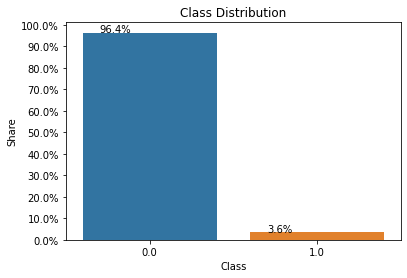

In [8]:
# Plotting the frequency of plugs and non-plugs in the form of a histogram
total = len(data_df)*1.
ax = sns.countplot(x="1282", data=data_df)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

# Put 11 ticks (therefore 10 steps) for each percentage multiple of 10, from 0 to 100.
ax.yaxis.set_ticks(np.linspace(0, total, 11))

# Adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.xlabel('Class')
plt.ylabel('Share')
plt.title('Class Distribution')
plt.show()

In [9]:
# Checking various statistical measures for the features before preprocessing.
data_df.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282
count,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,...,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,13008.000000,1.300800e+04,13008.000000
mean,0.114626,1.225099,-0.055551,-0.696714,0.684472,-0.068495,-0.409883,0.338800,-0.130258,0.816298,0.099361,-3.390177,0.483777,-0.307817,0.002812,0.140604,0.126219,0.055233,0.205721,-0.134090,0.320767,-0.040956,0.498403,-1.042625,-0.158796,0.208027,-1.031101,-0.603895,-3.100969,1.745075,-0.517466,-0.258712,0.056477,-0.081982,-0.569052,-0.515517,0.079225,-0.514322,-0.655361,-0.593858,...,0.738951,13.555377,-0.620816,-0.058048,-0.120647,-0.078850,0.230807,-0.384071,1.385846,-2.225135,-0.110613,0.334193,-0.106037,-2.376293,-0.546296,-0.871882,0.148605,-3.859195,0.234944,-0.162293,0.022123,-0.061505,-0.146054,0.138530,-0.255750,-0.729716,1.707375,0.243360,0.094963,0.499816,0.346051,-0.873384,0.269172,-0.554647,-0.410520,-0.027957,-0.725439,-0.307149,1.345647e+11,0.036208
std,1.073870,1.002393,0.849154,0.892555,0.942143,0.992696,0.987057,1.041153,1.254893,1.213444,0.952795,1.030717,0.939612,0.966672,1.020723,0.937968,0.978528,1.079988,0.985844,0.989380,0.966724,1.062603,1.171385,1.021726,1.077744,1.095953,1.030965,1.073281,1.256275,0.982816,1.121374,1.020246,1.225122,0.962314,1.054737,1.111547,1.012384,1.113010,1.046465,1.003712,...,1.120146,1.509211,1.080172,1.083533,1.080923,0.941460,0.994287,1.005919,1.239798,0.992883,1.011046,1.098447,1.126994,1.134850,1.184445,0.987019,1.207689,1.090159,1.061282,1.089641,1.038409,0.938941,1.043428,0.943280,1.084801,1.117355,1.186224,1.143499,1.222240,0.984234,1.014243,1.011318,0.895994,1.038625,0.969477,1.059394,1.021909,1.086673,2.164522e+11,0.186816
min,-3.487651,-1.934288,-2.906286,-3.912420,-2.932475,-3.358046,-4.126474,-3.720722,-4.353084,-4.303753,-2.927823,-7.588682,-3.242258,-4.451183,-3.496181,-3.059840,-3.604163,-3.630127,-3.435081,-4.837288,-3.373651,-3.655825,-3.477885,-5.210788,-4.210210,-4.309925,-5.392845,-4.320419,-8.317424,-1.514541,-4.027876,-3.890607,-4.311665,-3.176912,-4.223445,-5.538620,-3.354224,-4.563742,-4.386069,-5.435332,...,-3.365180,8.125070,-4.757225,-3.870456,-5.525675,-3.516924,-4.505627,-4.680343,-2.477931,-7.062493,-3.631871,-3.510733,-4.201579,-7.127813,-4.917585,-4.142203,-4.073263,-8.829903,-4.369545,-4.161530,-3.611106,-3.673469,-3.852768,-3.535051,-3.485762,-4.952300,-2.434984,-5.058459,-4.422781,-3.754989,-3.677469,-4.682764,-3.287710,-4.125988,-3.957365,-4.270917,-4.650285,-4.272482,5.940000e+00,0.000000
25%,-0.621451,0.544191,-0.656341,-1.287204,0.036336,-0.766531,-1.089964,-0.369419,-0.972761,0.013512,-0.543028,-4.066587,-0.166721,-0.898850,-0.713562,-0.511226,-0.543831,-0.691663,-0.458238,-0.753772,-0.320372,-0.765280,-0.342460,-1.702730,-0.878249,-0.522651,-1.700961,-1.302596,-3.907246,1.089053,-1.291535,-0.9

In [10]:
# Checking the number of products per prodect_space and the total number of product spaces.
data_df['1281'].value_counts()

6.038301e+10    190
6.748912e+10    181
5.870309e+10    159
6.038386e+10    143
6.038386e+10    138
               ... 
6.230071e+10      5
3.700081e+10      4
3.700095e+10      3
5.940000e+00      2
8.146690e+11      1
Name: 1281, Length: 298, dtype: int64

### Initial observations

*   There is major class imbalance with only ~ 3.6 percent of points being plugs.
*   The feature embeddings have both positive and negative values and seem to lie between (-10, 10). 
* The product spaces are of the order ~ e10.
* There are 298 distinct product spaces in which the number of items ranges from 1 to 190 (including plugs).


In [11]:
# Creating a dictionary for all the product_space values and their corresponding counts
ls = dict(data_df.groupby('1281')['1281'].count())

In [12]:
# Creating a dictionary of indices corresponding to each product space. Basically converting it into ordinal encoding.
indices = dict()
for i,k in enumerate(list(ls)):
    indices[k] = i
# print(indices)

In [13]:
# Cconverting '1281' into a cattegorical variable.
data_df['1281'] = data_df['1281'].apply(lambda x: indices[x])
data_df['1281'].head()

0    223
1    223
2    223
3    223
4     78
Name: 1281, dtype: int64

In [14]:
# Separating the three basic components of our data to carry out different operations on them. 
embeddings = data_df.drop(['1281', '1282'], axis = 1)
product_spaces = data_df['1281']
labels = data_df['1282']

print("labels -> " + str(labels.shape))
print("product_spaces -> " + str(product_spaces.shape))
print("embeddings -> " + str(embeddings.shape))

labels -> (13008,)
product_spaces -> (13008,)
embeddings -> (13008, 1280)


In [15]:
# https://stackoverflow.com/a/29651514
# We are normalizing the data so that the result of models like Logistic regression is not unduely influenced by the product_space feature that has a very high value
# as compared to the feature embedding values.
def normalize(df):
    result1 = df.copy()   # creating a copy of the dataframe 
    for feature_name in df.columns:   # iterating through all the columns
        if (str(feature_name) != '1282'):   # except the plug_labels (if present)
            max_value = df[feature_name].max()    # taking the maximum value in the column
            min_value = df[feature_name].min()    # taking the minimum value in the column
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)    # normalizing the value to the appropriate value between 0 and 1
    return result1

In [16]:
# This data contains a single column for product spaces where the values are normalized categorical values.
cat_data = normalize(data_df)
cat_data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282
0,0.374505,0.209009,0.606093,0.483468,0.512817,0.357224,0.523106,0.416514,0.352292,0.489581,0.544219,0.538257,0.744820,0.442311,0.282664,0.323545,0.542522,0.493778,0.424859,0.372873,0.562118,0.411209,0.420321,0.440745,0.246808,0.408171,0.649510,0.447911,0.630147,0.404816,0.372081,0.297190,0.474109,0.534515,0.268656,0.515049,0.442048,0.770196,0.371114,0.460560,...,0.485654,0.355500,0.715385,0.483636,0.548406,0.505680,0.753354,0.427314,0.291390,0.519542,0.617281,0.634397,0.421474,0.609769,0.610877,0.574720,0.586678,0.630292,0.627850,0.509205,0.480114,0.308099,0.484045,0.410418,0.589847,0.547817,0.342191,0.790782,0.661646,0.425751,0.574057,0.605543,0.423851,0.370466,0.796966,0.274984,0.566015,0.544203,0.750842,0.0
1,0.482190,0.159539,0.476374,0.536284,0.468343,0.365130,0.441168,0.479139,0.330806,0.474268,0.519795,0.669164,0.674079,0.413969,0.316697,0.478088,0.498880,0.380719,0.412642,0.472162,0.583079,0.483310,0.467218,0.490983,0.281842,0.436531,0.465656,0.493633,0.590987,0.452239,0.442870,0.208454,0.449047,0.638311,0.252059,0.433477,0.410622,0.669119,0.428294,0.272634,...,0.371078,0.372464,0.713941,0.642359,0.506761,0.386348,0.640466,0.396845,0.406394,0.576028,0.622108,0.672299,0.475426,0.608222,0.602845,0.529539,0.652835,0.619533,0.553051,0.608205,0.378755,0.357937,0.621334,0.340750,0.506534,0.549164,0.418405,0.703541,0.851610,0.464599,0.565222,0.590714,0.446868,0.344721,0.807560,0.338764,0.645935,0.497229,0.750842,0.0
2,0.408497,0.315416,0.501167,0.589591,0.507456,0.441906,0.566735,0.554191,0.373143,0.465627,0.613842,0.770376,0.528246,0.499600,0.419238,0.558880,0.403853,0.557335,0.448682,0.451084,0.542380,0.443350,0.509991,0.485835,0.297396,0.507311,0.597597,0.434658,0.583288,0.455927,0.437734,0.297884,0.609464,0.786053,0.230588,0.522506,0.459391,0.485463,0.337643,0.255738,...,0.346849,0.443940,0.709816,0.651631,0.476808,0.300473,0.544549,0.323862,0.399567,0.448388,0.548671,0.634051,0.441588,0.553889,0.413847,0.353599,0.695391,0.628790,0.497516,0.593568,0.425385,0.351759,0.630199,0.633059,0.605610,0.555684,0.457444,0.815746,0.726038,0.505130,0.530912,0.570468,0.389661,0.386650,0.784344,0.371293,0.554063,0.584206,0.750842,0.0
3,0.201570,0.424909,0.701910,0.593430,0.544852,0.206438,0.416476,0.386426,0.404823,0.567598,0.569446,0.576195,0.723633,0.406589,0.364659,0.438479,0.505458,0.547864,0.415114,0.497765,0.452015,0.424080,0.504823,0.457053,0.289993,0.535571,0.638981,0.504751,0.557101,0.452748,0.303588,0.467118,0.491563,0.712973,0.283775,0.542137,0.611304,0.674375,0.458064,0.382250,...,0.383079,0.379904,0.831554,0.583418,0.661343,0.418714,0.579380,0.397529,0.376054,0.496276,0.639974,0.648959,0.551979,0.717869,0.486195,0.595286,0.669757,0.637728,0.533553,0.605564,0.391211,0.108371,0.721728,0.495782,0.650130,0.622652,0.397679,0.706713,0.658857,0.476614,0.632512,0.487296,0.385368,0.436321,0.759671,0.304758,0.461488,0.537733,0.750842,0.0
4,0.351154,0.575216,0.434686,0.471893,0.488399,0.390737,0.449682,0.415712,0.241313,0.452964,0.501711,0.432275,0.593935,0.523617,0.347994,0.672635,0.225377,0.317863,0.637837,0.432007,0.741721,0.403161,0.322378,0.485640,0.481880,0.644761,0.667186,0.543697,0.555474,0.351248,0.460560,0.361131,0.321708,0.457149,0.352661,0.634697,0.360718,0.511714,0.733635,0.490071,...,0.367210,0.420970,0.731941,0.574919,0.483290,0.609556,0.470834,0.457870,0.528581,0.543076,0.518140,0.465597,0.586692,0.538738,0.403971,0.625675,0.365511,0.687406,0.594976,0.445104,0.266094,0.512146,0.437938,0.419539,0.465201,0.525977,0.454718,0.471506,0.845206,0.597640,0.582759,0.452020,0.599721,0.416633,0.406580,0.308399,0.651013,0.498934,0.262626,0.0


In [17]:
# Creating a dataframe of normalized embeddings to be used later.
normalized_embeddings = normalize(embeddings)
normalized_embeddings.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280
0,0.374505,0.209009,0.606093,0.483468,0.512817,0.357224,0.523106,0.416514,0.352292,0.489581,0.544219,0.538257,0.744820,0.442311,0.282664,0.323545,0.542522,0.493778,0.424859,0.372873,0.562118,0.411209,0.420321,0.440745,0.246808,0.408171,0.649510,0.447911,0.630147,0.404816,0.372081,0.297190,0.474109,0.534515,0.268656,0.515049,0.442048,0.770196,0.371114,0.460560,...,0.334786,0.285625,0.485654,0.355500,0.715385,0.483636,0.548406,0.505680,0.753354,0.427314,0.291390,0.519542,0.617281,0.634397,0.421474,0.609769,0.610877,0.574720,0.586678,0.630292,0.627850,0.509205,0.480114,0.308099,0.484045,0.410418,0.589847,0.547817,0.342191,0.790782,0.661646,0.425751,0.574057,0.605543,0.423851,0.370466,0.796966,0.274984,0.566015,0.544203
1,0.482190,0.159539,0.476374,0.536284,0.468343,0.365130,0.441168,0.479139,0.330806,0.474268,0.519795,0.669164,0.674079,0.413969,0.316697,0.478088,0.498880,0.380719,0.412642,0.472162,0.583079,0.483310,0.467218,0.490983,0.281842,0.436531,0.465656,0.493633,0.590987,0.452239,0.442870,0.208454,0.449047,0.638311,0.252059,0.433477,0.410622,0.669119,0.428294,0.272634,...,0.284630,0.255223,0.371078,0.372464,0.713941,0.642359,0.506761,0.386348,0.640466,0.396845,0.406394,0.576028,0.622108,0.672299,0.475426,0.608222,0.602845,0.529539,0.652835,0.619533,0.553051,0.608205,0.378755,0.357937,0.621334,0.340750,0.506534,0.549164,0.418405,0.703541,0.851610,0.464599,0.565222,0.590714,0.446868,0.344721,0.807560,0.338764,0.645935,0.497229
2,0.408497,0.315416,0.501167,0.589591,0.507456,0.441906,0.566735,0.554191,0.373143,0.465627,0.613842,0.770376,0.528246,0.499600,0.419238,0.558880,0.403853,0.557335,0.448682,0.451084,0.542380,0.443350,0.509991,0.485835,0.297396,0.507311,0.597597,0.434658,0.583288,0.455927,0.437734,0.297884,0.609464,0.786053,0.230588,0.522506,0.459391,0.485463,0.337643,0.255738,...,0.295143,0.426377,0.346849,0.443940,0.709816,0.651631,0.476808,0.300473,0.544549,0.323862,0.399567,0.448388,0.548671,0.634051,0.441588,0.553889,0.413847,0.353599,0.695391,0.628790,0.497516,0.593568,0.425385,0.351759,0.630199,0.633059,0.605610,0.555684,0.457444,0.815746,0.726038,0.505130,0.530912,0.570468,0.389661,0.386650,0.784344,0.371293,0.554063,0.584206
3,0.201570,0.424909,0.701910,0.593430,0.544852,0.206438,0.416476,0.386426,0.404823,0.567598,0.569446,0.576195,0.723633,0.406589,0.364659,0.438479,0.505458,0.547864,0.415114,0.497765,0.452015,0.424080,0.504823,0.457053,0.289993,0.535571,0.638981,0.504751,0.557101,0.452748,0.303588,0.467118,0.491563,0.712973,0.283775,0.542137,0.611304,0.674375,0.458064,0.382250,...,0.310491,0.315208,0.383079,0.379904,0.831554,0.583418,0.661343,0.418714,0.579380,0.397529,0.376054,0.496276,0.639974,0.648959,0.551979,0.717869,0.486195,0.595286,0.669757,0.637728,0.533553,0.605564,0.391211,0.108371,0.721728,0.495782,0.650130,0.622652,0.397679,0.706713,0.658857,0.476614,0.632512,0.487296,0.385368,0.436321,0.759671,0.304758,0.461488,0.537733
4,0.351154,0.575216,0.434686,0.471893,0.488399,0.390737,0.449682,0.415712,0.241313,0.452964,0.501711,0.432275,0.593935,0.523617,0.347994,0.672635,0.225377,0.317863,0.637837,0.432007,0.741721,0.403161,0.322378,0.485640,0.481880,0.644761,0.667186,0.543697,0.555474,0.351248,0.460560,0.361131,0.321708,0.457149,0.352661,0.634697,0.360718,0.511714,0.733635,0.490071,...,0.524774,0.436338,0.367210,0.420970,0.731941,0.574919,0.483290,0.609556,0.470834,0.457870,0.528581,0.543076,0.518140,0.465597,0.586692,0.538738,0.403971,0.625675,0.365511,0.687406,0.594976,0.445104,0.266094,0.512146,0.437938,0.419539,0.465201,0.525977,0.454718,0.471506,0.845206,0.597640,0.582759,0.452020,0.599721,0.416633,0.406580,0.308399,0.651013,0.498934


In [18]:
# Convering the categrical feature of 'product_spaces' to one-hot-encoding
ohe = OneHotEncoder()   # Initializing the object
product_spaces = np.expand_dims(product_spaces, axis=1)   # Expanding the dimensions. Required for passing into ohe.
product_spaces_ohe = ohe.fit_transform(product_spaces)    # Yields a sparse matrix of shape (13008, 298) containing the one-hot-encoded vectors
product_spaces_ohe.toarray().shape    

(13008, 298)

In [19]:
# Demonstrating that we can get the initial index value back from the one-hot-encoded vector of any product space(s)
ohe.inverse_transform(product_spaces_ohe)

array([[223],
       [223],
       [223],
       ...,
       [264],
       [277],
       [276]])

In [20]:
# Demonstrating that we can get the initial index value back from the one-hot-encoded vector of any product space(s)
list(ls)[223]

67140700337.0

In [21]:
# The forms and shapes of the three components of our data that we are going to use
print(np.array(normalized_embeddings).shape)
print(np.expand_dims(labels, axis=1).shape)
print(product_spaces_ohe.toarray().shape)

(13008, 1280)
(13008, 1)
(13008, 298)


In [22]:
# This is the data wherein 'product_space' is a one-hot-encoded feature
# 'hstack' is joining all three arrays column-wise.
# Hence the number of columns is 1280 + 298 + 1 = 1579
ohe_data = np.hstack((np.array(normalized_embeddings), product_spaces_ohe.toarray(), np.expand_dims(labels, axis=1)))
ohe_data.shape

(13008, 1579)

In [23]:
# Creating all the column names in string format
cols = [str(i) for i in range(1, 1580)] 

# Making a dataframe out of this array where
# '1' to '1280' -> embedding features
# '1281' to '1578' -> product_space one-hot-encoded features
# '1579' -> plug_label
ohe_data = pd.DataFrame(ohe_data, columns = cols)
ohe_data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579
0,0.374505,0.209009,0.606093,0.483468,0.512817,0.357224,0.523106,0.416514,0.352292,0.489581,0.544219,0.538257,0.744820,0.442311,0.282664,0.323545,0.542522,0.493778,0.424859,0.372873,0.562118,0.411209,0.420321,0.440745,0.246808,0.408171,0.649510,0.447911,0.630147,0.404816,0.372081,0.297190,0.474109,0.534515,0.268656,0.515049,0.442048,0.770196,0.371114,0.460560,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.482190,0.159539,0.476374,0.536284,0.468343,0.365130,0.441168,0.479139,0.330806,0.474268,0.519795,0.669164,0.674079,0.413969,0.316697,0.478088,0.498880,0.380719,0.412642,0.472162,0.583079,0.483310,0.467218,0.490983,0.281842,0.436531,0.465656,0.493633,0.590987,0.452239,0.442870,0.208454,0.449047,0.638311,0.252059,0.433477,0.410622,0.669119,0.428294,0.272634,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.408497,0.315416,0.501167,0.589591,0.507456,0.441906,0.566735,0.554191,0.373143,0.465627,0.613842,0.770376,0.528246,0.499600,0.419238,0.558880,0.403853,0.557335,0.448682,0.451084,0.542380,0.443350,0.509991,0.485835,0.297396,0.507311,0.597597,0.434658,0.583288,0.455927,0.437734,0.297884,0.609464,0.786053,0.230588,0.522506,0.459391,0.485463,0.337643,0.255738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.201570,0.424909,0.701910,0.593430,0.544852,0.206438,0.416476,0.386426,0.404823,0.567598,0.569446,0.576195,0.723633,0.406589,0.364659,0.438479,0.505458,0.547864,0.415114,0.497765,0.452015,0.424080,0.504823,0.457053,0.289993,0.535571,0.638981,0.504751,0.557101,0.452748,0.303588,0.467118,0.491563,0.712973,0.283775,0.542137,0.611304,0.674375,0.458064,0.382250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.351154,0.575216,0.434686,0.471893,0.488399,0.390737,0.449682,0.415712,0.241313,0.452964,0.501711,0.432275,0.593935,0.523617,0.347994,0.672635,0.225377,0.317863,0.637837,0.432007,0.741721,0.403161,0.322378,0.485640,0.481880,0.644761,0.667186,0.543697,0.555474,0.351248,0.460560,0.361131,0.321708,0.457149,0.352661,0.634697,0.360718,0.511714,0.733635,0.490071,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Checking the number of plugs and non-plugs in the data (sanity check for confirmation)
ohe_data['1579'].value_counts()

0.0    12537
1.0      471
Name: 1579, dtype: int64

### T-SNE plots for all types of data

In [ ]:
# https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib
# Setting the constant figure size to (20, 10)
rcParams['figure.figsize'] = 20, 10

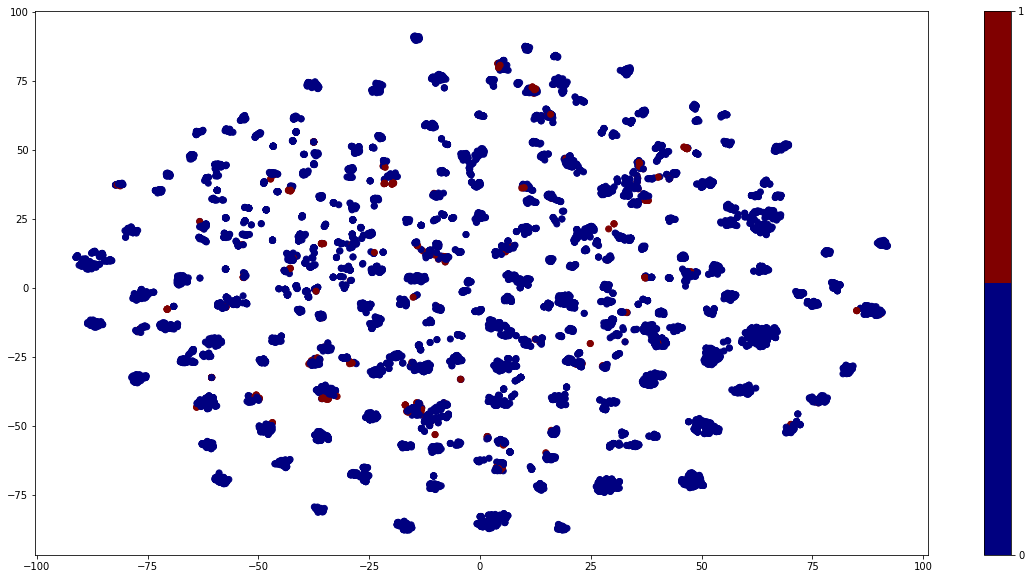

In [ ]:
# The data where the product spaces are being used as one-hot-encoded features
result = ohe_data
data_y = ohe_data['1579']
# multivariate analysis on byte files
# this is with perplexity 50
xtsne = TSNE(perplexity=50)
results = xtsne.fit_transform(result.drop(['1579'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 2))
plt.colorbar(ticks=range(2))
plt.show()

Some amount of separation can be observed between clusters of plugs and those of non-plugs (the majority). It can also be observed that the number of clearly separable clusters is of the order of the number of unique product spaces. Hence, it won't be unwise to try to separate plugs from non-plugs using classifiers that use neighbor information.

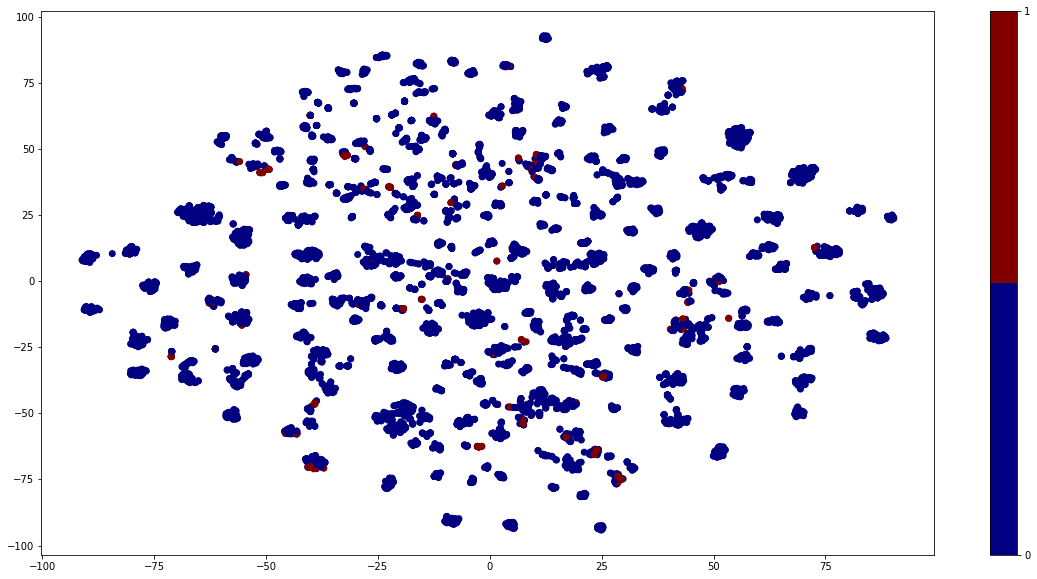

In [ ]:
# The data where the product spaces are being used as natural number features
result = cat_data
data_y = cat_data['1282']
# multivariate analysis on byte files
# this is with perplexity 50
xtsne = TSNE(perplexity=50)
results = xtsne.fit_transform(result.drop(['1282'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 2))
plt.colorbar(ticks=range(2))
plt.show()

There is no significant difference between clusters of same and different classes in this plot as compared to the previous one. Hence, we should try both feature sets and determine what works better in practice.

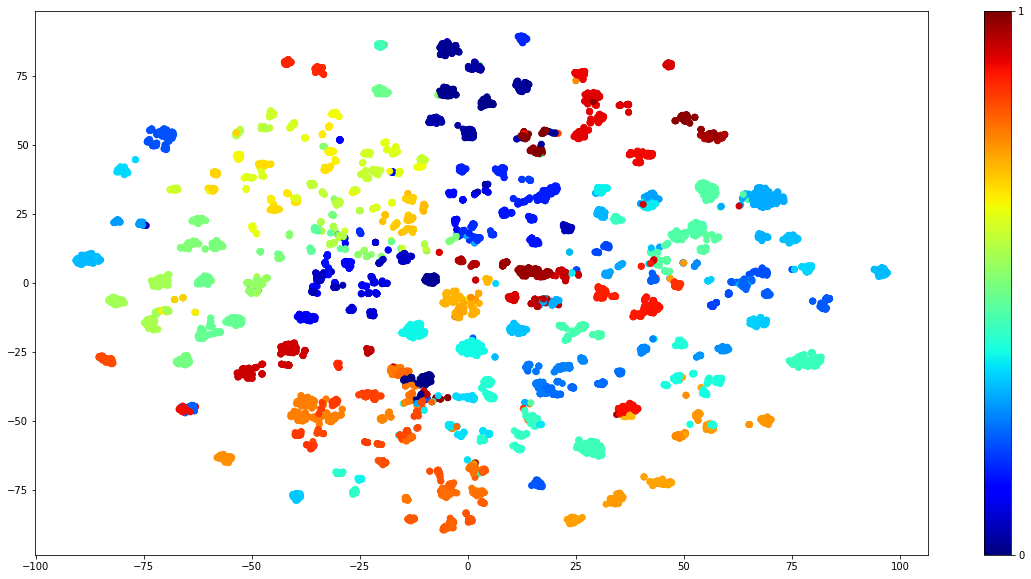

In [ ]:
# The data where the product spaces are being used as labels
result = cat_data
data_y = cat_data['1281']
# multivariate analysis on byte files
# this is with perplexity 50
xtsne = TSNE(perplexity=50)
results = xtsne.fit_transform(result.drop(['1282', '1281'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 298))
plt.colorbar(ticks=range(298))
plt.show()

Quite clearly, we are able to separate the items based on product spaces significantly well in two dimensions itself. This is a motivation for us to train a model to learn the relationship between image features and product spaces, predict the product space for any item, and check whether it is correctly/incorrectly predicted.

## The two ways of using this data
From our findings above, we conclude that there are two main methods in which we can use the data provided to us by the retailer.

1.   Using product_space as a feature and plug_label as the target. This way we are checking for any given item (embeddings) and product space, if the placement/pairing is correct. The plug label (target) is 0 if yes, otherwise it is 1. We will try this in the following two ways:

  * Using the indexes of product spaces as the input along with embeddings. The total input shape would be (13008, 1281) in this case.
  * Using the one-hot-encoded representations of the product spaces along with the embeddings. The total input shape will be (13008, 1578) in this case.

  The shape of the output in both cases will be (13008,).

  We will these approaches for out machine learning models as well as with an neural network architecture.

2.   Using product_space as the target. We will only use only non-plugs while training this model. We will train a deep neural network to learn the relationship between items and product spaces. After it learns this, we will use the test data (already set aside) to predict the product spaces for each item. We will then check whether it is the prediction is matching in case of non-plugs, and whether it is different in the case of plugs. The shape of the input will be (13008, 1280) and that of the output will be (13008, 298).



First we will use approach 1.

In [25]:
# Splitting the data into two parts
#   1) To be used in the traing process (train + cross validation) -> X
#   2) To be used simply for testing, as a set of new queries -> x_unb
# The ratio of X:x_unb in terms for size is 4:1
# The 'stratified' split ensures that the relative representation of classes remains same in both the sets.
X_cat, x_unb_cat, Y_cat, y_unb_cat = train_test_split(cat_data.drop(['1282'], axis = 1), cat_data['1282'], stratify = cat_data['1282'], test_size = 0.2, random_state = 24)

In [26]:
# Splitting the data into two parts
#   1) To be used in the traing process (train + cross validation) -> X
#   2) To be used simply for testing, as a set of new queries -> x_unb
# The ratio of X:x_unb in terms for size is 4:1
# The 'stratified' split ensures that the relative representation of classes remains same in both the sets.
X, x_unb, Y, y_unb = train_test_split(ohe_data.drop(['1579'], axis = 1), ohe_data['1579'], stratify = ohe_data['1579'], test_size = 0.2, random_state = 0)

x_unb(_cat) has been separated out in the beginning and won't be used during training at all. This split ratio was chosen to simulate the real world situation in which most queries would have a majority on non-plugs and a minority of plugs. We are assuming this considering the manner in which the training data was given to us.

All the data sets with the '_cat' suffix are those that have been derived from the data where there is only one column containing product space information in terms of index values of the product space. The other data sets are derived from the data that contains product spaces and one-hot-encoded features. 

In [27]:
print(X.shape, x_unb.shape)
print(type(Y))

(10406, 1578) (2602, 1578)
<class 'pandas.core.series.Series'>


In [28]:
# After separating a part of the data for testing later, we are combining the input and target into the same dataframe again so that we can upsample the minority class
X = pd.concat((X, Y), axis=1)
X_cat = pd.concat((X_cat, Y_cat), axis=1)
print(X.shape)
print(X_cat.shape)

(10406, 1579)
(10406, 1282)


In [29]:
# https://elitedatascience.com/imbalanced-classes
# Here we are trying to balance the classes for better training
from sklearn.utils import resample

df_majority = X[X['1579']==0]   # All the non-plugs
df_minority = X[X['1579']==1]   # All the plugs
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=4000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['1579'].value_counts()

0.0    10029
1.0     4000
Name: 1579, dtype: int64

In [30]:
# https://elitedatascience.com/imbalanced-classes
# Here we are trying to balance the classes for better training
from sklearn.utils import resample

df_majority_cat = X_cat[X_cat['1282']==0]   # All the non-plugs
df_minority_cat = X_cat[X_cat['1282']==1]   # All the plugs
 
# Upsample minority class
df_minority_upsampled_cat = resample(df_minority_cat, 
                                 replace=True,     # sample with replacement
                                 n_samples=4000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled_cat = pd.concat([df_majority_cat, df_minority_upsampled_cat])
 
# Display new class counts
df_upsampled_cat['1282'].value_counts()

0.0    10029
1.0     4000
Name: 1282, dtype: int64

The number of samples after upsampling was decided after a lot of trial and error. 4000 seemed to be the most suitable number of upsampled plugs. There is no denying that there might be a better number as well.

In [31]:
# Partitioning the data into input and output again
x_train = df_upsampled.drop(['1579'], axis = 1)
y_train = df_upsampled['1579']

In [32]:
# Partitioning the data into input and output again
x_train_cat = df_upsampled_cat.drop(['1282'], axis = 1)
y_train_cat = df_upsampled_cat['1282']

In [33]:
# Splitting the data into 'train' and 'cv' (cross validation) sets in a stratified manner
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, stratify = y_train, test_size = 0.2, random_state = 42)
print(x_train.shape, y_cv.shape)
print(y_train.value_counts(), y_cv.value_counts())

(11223, 1578) (2806,)
0.0    8023
1.0    3200
Name: 1579, dtype: int64 0.0    2006
1.0     800
Name: 1579, dtype: int64


In [34]:
# Splitting the data into 'train' and 'cv' (cross validation) sets in a stratified manner
x_train_cat, x_cv_cat, y_train_cat, y_cv_cat = train_test_split(x_train_cat, y_train_cat, stratify = y_train_cat, test_size = 0.2, random_state = 42)
print(x_train_cat.shape, y_cv_cat.shape)
print(y_train_cat.value_counts(), y_cv_cat.value_counts())

(11223, 1281) (2806,)
0.0    8023
1.0    3200
Name: 1282, dtype: int64 0.0    2006
1.0     800
Name: 1282, dtype: int64



*   x_train and x_test are appropriately upsampled for training.
*   x_cv and y_cv contain the same proportion of plugs/non-plugs x_train/y_train.

*   x_unb and y_unb contain the same proportion of plugs/non-plugs as the original data.



In [36]:
import pickle
pickle.dump((X, Y), open('drive/My Drive/Retail Task/X_Y', 'wb'))
pickle.dump((x_unb, y_unb), open('drive/My Drive/Retail Task/x_y_unb', 'wb'))
pickle.dump((x_unb_cat, y_unb_cat), open('drive/My Drive/Retail Task/x_y_unb_cat', 'wb'))
pickle.dump((X_cat, Y_cat), open('drive/My Drive/Retail Task/X_Y_cat', 'wb'))
pickle.dump((x_train, y_train), open('drive/My Drive/Retail Task/x_y_train', 'wb'))
pickle.dump((x_train_cat, y_train_cat), open('drive/My Drive/Retail Task/x_y_train_cat', 'wb'))
pickle.dump((x_cv, y_cv), open('drive/My Drive/Retail Task/x_y_cv', 'wb'))
pickle.dump((x_cv_cat, y_cv_cat), open('drive/My Drive/Retail Task/x_y_cv_cat', 'wb'))